In [1]:
using PyPlot
using Distributions
using LinearAlgebra
using Formatting
using Flux
using Flux: Tracker
using StatsBase: countmap
using Clustering

### Define a few useful functions for later
(Not terribly important)

In [9]:
hstack(x) = reduce(hcat, x)
splatc(x::AbstractArray) = [x[:,i] for i in range(1,stop=size(x,2))]

splatc (generic function with 1 method)

In [2]:
function gaussian_2D_level_curve(mu::Array{Float64,1}, sigma::Array{Float64, 2}, alpha=2, ncoods=100)
    # Return coordinates for alpha (default=2) level curve for given Gaussian
    @assert size(mu) == (2,) "mu must be vector in R^2"
    @assert size(sigma) == (2, 2) "sigma must be 2x2 array"

    U, S, V = svd(sigma)

    sd = sqrt.(S)
    coods = range(0, stop=2*pi, length=ncoods)
    coods = hstack((sd[1] * cos.(coods), sd[2] * sin.(coods)))' * alpha
    
    coods = (V' * coods)' # project onto basis of ellipse
    coods = coods .+ mu' # add mean
    return coods
end

gaussian_2D_level_curve (generic function with 3 methods)

## Set up problem data: Mixture of Gaussians

In [5]:
const mus =  [-8.24792   -7.22486;
               1.88523    0.470692;
              -6.16808    8.5335;
               0.273647   3.00132]

const UTs = [[1.86038 0.869847; 0.0 0.414693], [1.32273 0.0985234; 0.0 0.363965], [1.16059 -0.23332; 0.0 0.480219],[0.318648 0.277103; 0.0 2.4839]]
const invUTs = [Matrix(cholesky(inv(x'*x)).U) for x in UTs]
const mixpi = [.25 for i in 1:4]

4-element Array{Float64,1}:
 0.25
 0.25
 0.25
 0.25

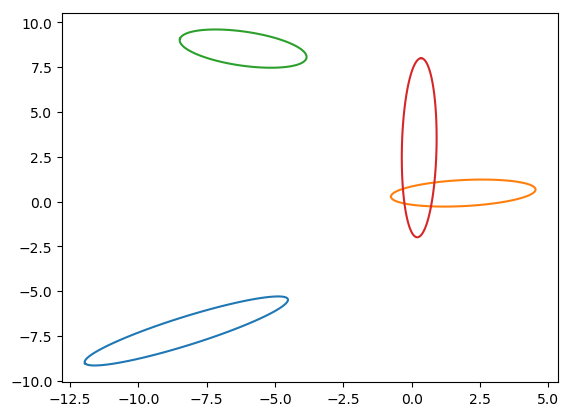

In [15]:
for i = 1:4; plot(splatc(gaussian_2D_level_curve(mus[i,:],UTs[i]'UTs[i]))...); end

## Define Logsumexp function for use in AD

In [13]:
using Flux.Tracker: TrackedReal, track, @grad

function logsumexp(X::AbstractArray{T}) where {T<:Real}
    # yanked from https://github.com/JuliaStats/StatsFuns.jl/blob/master/src/basicfuns.jl
    isempty(X) && return log(zero(T))
    u = maximum(X)
    isfinite(u) || return float(u)
    let u=u # avoid https://github.com/JuliaLang/julia/issues/15276
        u + log.(sum(x -> exp.(x-u), X))
    end
end

function logsumexprows(X::AbstractArray{T}) where {T<:Real}
    n = size(X,1)
    out = zeros(n)
    for i = 1:n
        out[i] = logsumexp(X[i,:])
    end
    return out
end   

# Avoid collision with NNLib softmax for playing around
function softmax2(logp; dims=2)
    p = exp.(logp .- maximum(logp, dims=dims))
    p ./= sum(p, dims=dims)
    return p
end

softmax2 (generic function with 1 method)

### Plug into Flux

In [14]:
logsumexprows(X::TrackedArray) = Tracker.track(logsumexprows, X)

@grad function logsumexprows(X)
  return logsumexprows(X.data), Δ -> (Δ .* softmax2(Δ.*X.data),)
end

--------------------
# Main Event
-------------------

## Evaluate Log Probability

In [24]:
function _p_log_target_component(X, i)
    d = size(X,2)
    Z = (X .- mus[i,:]')*invUTs[i]'   # <-- transform X
    exponent = -0.5*sum(Z.^2, dims=2)  # <-- sum squared X
    lognormconst = -d*log(2*pi)/2 .- sum(log.(diag(UTs[i])))  # CONSTANT
    return exponent .+ lognormconst .+ log(mixpi[i])  # ADD CONSTANTS
end

function p_log_target(X)
    @assert ndims(X) == 2
    n, d = size(X)
    @assert d != 1
    
    P = reduce(hcat, map(ix -> _p_log_target_component(X, ix), 1:4))  # <-- (****)
    
    println("Contents of P:")
    flush(stdout)
    display(P)
    
    return logsumexprows(P) # FLUX: ADDED ABOVE
end

p_log_target (generic function with 1 method)

It is the line marked `# <-- (****)` where I've stacked the results of 4 separate transformations (according to the 4 Gaussian components) where the Tracked Array turns into an array of Tracked Reals. This breaks the function
```julia 
logsumexprows(X::TrackedArray) = Tracker.track(logsumexprows, X)
```
since it is no longer the correct signature (and probably suboptimal).

In [25]:
a = [1. 3.; 2. 4.4]
a = Tracker.param(a)
println("Contents of a:")
flush(stdout)
display(a)
Tracker.back!(sum(p_log_target(a)))
a.grad

Contents of a:


Tracked 2×2 Array{Float64,2}:
 1.0  3.0
 2.0  4.4

Contents of P:


2×4 Array{TrackedReal{Float64},2}:
 -116.559 (tracked)  -28.139 (tracked)   …   -5.62083 (tracked)
 -153.898 (tracked)  -60.5187 (tracked)     -17.6672 (tracked) 

LoadError: MethodError: no method matching Float64(::TrackedReal{Float64})
Closest candidates are:
  Float64(::Real, !Matched::RoundingMode) where T<:AbstractFloat at rounding.jl:185
  Float64(::T<:Number) where T<:Number at boot.jl:725
  Float64(!Matched::Int8) at float.jl:60
  ...